# Stock Market Co-movement Pre-clustering

## Dataset Information
The dataset is obtained from Free88.org: http://free88.org/klse.html

This is a reformatted dataset which includes the end of day (EOD) stock market data from 26 April to 15 May 2018, from KLSE website on every weekday basis at 6:30pm.

## Attribute Information
1) NAME: Stock name.

2) TICKER: Stock abbreviation.

3) PER: Period (D means per day).

4) DATE: Date (e.g. 20180426).

5) OPEN: Opening price of the day.

6) HIGH: Highest price of the day.

7) LOW: Lowest price of the day.

8) CLOSE: Closing price of the day.

9) VOL: Volume of the day.

10) OPENINT: Open interest of the day.

## Analysis Objective
To group the stocks into different clusters through their daily closing price time series (using low-resolution pattern rather than original pattern) from 26 April to 15 May 2018.

## Data Preparation
All the modules that will be used in this notebook are loaded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from kmodes.kmodes import KModes

### Load Data
Data is loaded and cleaned.

In [2]:
# include the available stock market dates in list
list_date = ['20180426', '20180427', '20180430', '20180502', '20180503',
            '20180504', '20180507', '20180508', '20180514', '20180515']

list_datecol = []

cnt_concat = 0

for date in list_date:
    # read the datafile by date
    df_temp = pd.read_csv('../data/KLSE_%s.csv' % date)
    
    # remove rows with irrelevant date
    df_temp = df_temp[df_temp['DATE']==int(date)]
    
    # remove rows with null values in NAME and CLOSE attribute
    df_temp.dropna(axis=0, subset=['NAME', 'CLOSE'], inplace=True)
    
    # remove duplicate rows
    df_temp.drop_duplicates(inplace=True)
    
    # keep NAME and CLOSE (according date) attribute only
    df_temp = df_temp[['NAME', 'CLOSE']]
    val_datecol = 'CLS_%s' % date[-6:]
    df_temp.columns = ['NAME', val_datecol]
    list_datecol.append(val_datecol)
    
    # add new CLS (according new date) attribute
    if cnt_concat == 0:
        df_init = df_temp.copy()
    else:
        df_init = pd.concat([df_init, df_temp[val_datecol]], axis=1,
                            join='inner')
    cnt_concat += 1

# show first 5 rows
display(df_init[:5])

print('There\'re %d rows and %d attributes in dataframe.' % (df_init.shape))

,NAME,CLS_180426,CLS_180427,CLS_180430,CLS_180502,CLS_180503,CLS_180504,CLS_180507,CLS_180508,CLS_180514,CLS_180515
0,NEGRI SEMBILAN OIL PALMS BERHAD (2038),1.510,1.500,1.520,1.530,1.520,1.500,1.500,1.530,1.540,1.540
1,A50CHIN-C12,0.055,0.050,0.055,0.040,0.040,0.035,0.045,0.050,0.060,0.060
2,ABF MALAYSIA BOND INDEX FUND,1.153,1.153,1.153,1.153,1.153,1.153,1.155,1.155,1.155,1.155
3,A50CHIN-C13,0.300,0.300,0.300,0.300,0.210,0.210,0.210,0.240,0.240,0.240
4,ABLEGROUP BERHAD (7086.KL),0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.105,0.105


There're 1875 rows and 11 attributes in dataframe.


The following information about the attributes in dataframe are displayed:

1) Data type

2) Number of null values

3) Percentage of null values, with respect to the total number of rows

In [3]:
# display the table with info of data type and null values for each attribute
tab_info = pd.DataFrame(df_init.dtypes).T.rename(index={0:'Data Type'})
tab_info = tab_info.append(pd.DataFrame(df_init.isnull().sum()).T
                           .rename(index={0:'Null Values (#)'}))
tab_info = tab_info.append(pd.DataFrame(df_init.isnull().sum()/
                                        df_init.shape[0]*100).T
                           .rename(index={0:'Null Values (%)'}))
display(tab_info)

,NAME,CLS_180426,CLS_180427,CLS_180430,CLS_180502,CLS_180503,CLS_180504,CLS_180507,CLS_180508,CLS_180514,CLS_180515
Data Type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Null Values (#),0,0,0,0,0,0,0,0,0,0,0
Null Values (%),0,0,0,0,0,0,0,0,0,0,0


The dataframe is 100% filled with values for all attributes.

### Transform Data
The time series data is transformed from dataframe attribute to array form for the following pre-clustering analysis purpose.

In [4]:
# create a dataframe with CLS related attributes in array form
df_final = pd.DataFrame({0:df_init['NAME'],
                         1:df_init.apply(lambda x:tuple(x[list_datecol]),
                                         axis=1)
                         .apply(np.array)}).rename(columns={0:'NAME',
                                                            1:'CLS_ALL'})

# show first 5 rows
display(df_final[:5])

print('There\'re %d rows and %d attributes in dataframe.' % (df_final.shape))

,NAME,CLS_ALL
0,NEGRI SEMBILAN OIL PALMS BERHAD (2038),"[1.51, 1.5, 1.52, 1.53, 1.52, 1.5, 1.5, 1.53, ..."
1,A50CHIN-C12,"[0.055, 0.05, 0.055, 0.04, 0.04, 0.035, 0.045,..."
2,ABF MALAYSIA BOND INDEX FUND,"[1.153, 1.153, 1.153, 1.153, 1.153, 1.153, 1.1..."
3,A50CHIN-C13,"[0.3, 0.3, 0.3, 0.3, 0.21, 0.21, 0.21, 0.24, 0..."
4,ABLEGROUP BERHAD (7086.KL),"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.105..."


There're 1875 rows and 2 attributes in dataframe.


## Stock Pre-clustering
### Reduce Dimensionality
The data is now ready for pre-clustering analysis purpose. The content of CLS_ALL attribute is used as the input of time series data to be reduced its dimensionality further.

In [5]:
# Z-normalization of all time series
df_final['ZNORM'] = df_final['CLS_ALL'].apply(lambda x:znorm(x))

# Piecewise Aggregate Approximation (PAA) to 4 points
cnt_PAA = 4
df_final['PAA_%d' % cnt_PAA] = df_final['ZNORM'].apply(
    lambda x:paa(x, cnt_PAA))

# Symbolic Aggregate Approximation (SAX) with 3 word sizes (e.g. abc)
cnt_SAX = 3
df_final['SAX_%d' % cnt_SAX] = df_final['PAA_%d' % cnt_PAA].apply(
    lambda x:ts_to_string(x, cuts_for_asize(cnt_SAX)))

# show first 5 rows
display(df_final[:5])

print('There\'re %d rows and %d attributes in dataframe.' % (df_final.shape))

,NAME,CLS_ALL,ZNORM,PAA_4,SAX_3
0,NEGRI SEMBILAN OIL PALMS BERHAD (2038),"[1.51, 1.5, 1.52, 1.53, 1.52, 1.5, 1.5, 1.53, ...","[-0.5947367404095588, -1.2555553408646485, 0.0...","[-0.7269004605005767, 0.33040930022756687, -0....",abac
1,A50CHIN-C12,"[0.055, 0.05, 0.055, 0.04, 0.04, 0.035, 0.045,...","[0.055, 0.05, 0.055, 0.04, 0.04, 0.035, 0.045,...","[0.053000000000000005, 0.043, 0.04199999999999...",bbbb
2,ABF MALAYSIA BOND INDEX FUND,"[1.153, 1.153, 1.153, 1.153, 1.153, 1.153, 1.1...","[1.153, 1.153, 1.153, 1.153, 1.153, 1.153, 1.1...","[1.1530000000000002, 1.1530000000000002, 1.154...",cccc
3,A50CHIN-C13,"[0.3, 0.3, 0.3, 0.3, 0.21, 0.21, 0.21, 0.24, 0...","[1.167748416242284, 1.167748416242284, 1.16774...","[1.1677484162422842, 0.23354968324845649, -1.0...",cbab
4,ABLEGROUP BERHAD (7086.KL),"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.105...","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.105...","[0.09999999999999999, 0.09999999999999999, 0.0...",bbbb


There're 1875 rows and 5 attributes in dataframe.


PAA size is chosen to be 4 points after observing the trends of some Z-normalized time series data points as below.

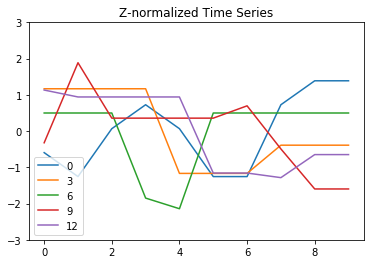

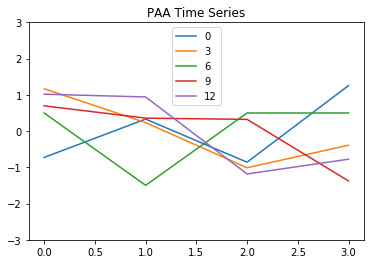

,NAME,CLS_ALL,ZNORM,PAA_4,SAX_3
0,NEGRI SEMBILAN OIL PALMS BERHAD (2038),"[1.51, 1.5, 1.52, 1.53, 1.52, 1.5, 1.5, 1.53, ...","[-0.5947367404095588, -1.2555553408646485, 0.0...","[-0.7269004605005767, 0.33040930022756687, -0....",abac
3,A50CHIN-C13,"[0.3, 0.3, 0.3, 0.3, 0.21, 0.21, 0.21, 0.24, 0...","[1.167748416242284, 1.167748416242284, 1.16774...","[1.1677484162422842, 0.23354968324845649, -1.0...",cbab
6,ABM FUJIYA BERHAD [S] (5198.KL),"[0.42, 0.42, 0.42, 0.38, 0.375, 0.42, 0.42, 0....","[0.49892218025118423, 0.49892218025118423, 0.4...","[0.4989221802511842, -1.496766540753563, 0.498...",cacc
9,A50CHIN-H15,"[1.06, 1.19, 1.1, 1.1, 1.1, 1.1, 1.12, 1.05, 0...","[-0.3228231413645261, 1.8859667732348722, 0.35...","[0.6966183576813504, 0.35680452466605905, 0.32...",cbba
12,ACOUSTECH BHD(7061.KL),"[0.4, 0.385, 0.385, 0.385, 0.385, 0.22, 0.22, ...","[1.132220226459535, 0.9413965927865796, 0.9413...","[1.017726046255762, 0.9413965927865797, -1.183...",ccaa


In [6]:
# rows are picked from dataframe to visualize the trends
list_no = [0, 3, 6, 9, 12]

# visualize Z-normalized time series
cnt_append = 0

for no in list_no:
    pd.Series(df_final['ZNORM'][no]).plot()
    if cnt_append == 0:
        tab_temp = pd.DataFrame(df_final[df_final.index==no])
    else:
        tab_temp = tab_temp.append(pd.DataFrame(df_final[df_final.index==no]))
    cnt_append += 1

plt.title('Z-normalized Time Series')
plt.ylim(-3,3)
plt.legend(list_no)
plt.show()

# visualize PAA time series
cnt_append = 0

for no in list_no:
    pd.Series(df_final['PAA_%d' % cnt_PAA][no]).plot()

plt.title('PAA Time Series')
plt.ylim(-3,3)
plt.legend(list_no)
plt.show()

# show rows involved
display(tab_temp)

### Compute Distance Measure
Function DTWDistance is defined to find the optimal non-linear path (Dynamic Time Warping distance) between two time series with the minimum Euclidean distance.

In [7]:
def DTWDistance(s1, s2, w):
    DTW = {}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1, len(s1)):
        for j in range(-1, len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)],
                                     DTW[(i-1, j-1)])
    
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

The DTWDistance is computed for pairs of PAA time series picked as in above visualiztion mentioned.

In [8]:
list_pairno = []

for i in range(len(list_no)-1):
    j = i + 1
    while j <= len(list_no)-1:
        list_pairno.append((list_no[i], list_no[j]))
        j += 1

display(list_pairno)

# compute DTWDistance between pairs of time series
for pairno in list_pairno:
    print('DTWDistance between time series %d and %d: %f'
          % (pairno[0], pairno[1],
             DTWDistance(df_final['PAA_%d' % cnt_PAA][pairno[0]],
                         df_final['PAA_%d' % cnt_PAA][pairno[1]], 2)))

# show rows involved
display(tab_temp)

[(0, 3),
 (0, 6),
 (0, 9),
 (0, 12),
 (3, 6),
 (3, 9),
 (3, 12),
 (6, 9),
 (6, 12),
 (9, 12)]

DTWDistance between time series 0 and 3: 2.515524
DTWDistance between time series 0 and 6: 1.755759
DTWDistance between time series 0 and 9: 3.036613
DTWDistance between time series 0 and 12: 2.765739
DTWDistance between time series 3 and 6: 1.526565
DTWDistance between time series 3 and 9: 1.162724
DTWDistance between time series 3 and 12: 0.838095
DTWDistance between time series 6 and 9: 2.630105
DTWDistance between time series 6 and 12: 1.953013
DTWDistance between time series 9 and 12: 1.106829


,NAME,CLS_ALL,ZNORM,PAA_4,SAX_3
0,NEGRI SEMBILAN OIL PALMS BERHAD (2038),"[1.51, 1.5, 1.52, 1.53, 1.52, 1.5, 1.5, 1.53, ...","[-0.5947367404095588, -1.2555553408646485, 0.0...","[-0.7269004605005767, 0.33040930022756687, -0....",abac
3,A50CHIN-C13,"[0.3, 0.3, 0.3, 0.3, 0.21, 0.21, 0.21, 0.24, 0...","[1.167748416242284, 1.167748416242284, 1.16774...","[1.1677484162422842, 0.23354968324845649, -1.0...",cbab
6,ABM FUJIYA BERHAD [S] (5198.KL),"[0.42, 0.42, 0.42, 0.38, 0.375, 0.42, 0.42, 0....","[0.49892218025118423, 0.49892218025118423, 0.4...","[0.4989221802511842, -1.496766540753563, 0.498...",cacc
9,A50CHIN-H15,"[1.06, 1.19, 1.1, 1.1, 1.1, 1.1, 1.12, 1.05, 0...","[-0.3228231413645261, 1.8859667732348722, 0.35...","[0.6966183576813504, 0.35680452466605905, 0.32...",cbba
12,ACOUSTECH BHD(7061.KL),"[0.4, 0.385, 0.385, 0.385, 0.385, 0.22, 0.22, ...","[1.132220226459535, 0.9413965927865796, 0.9413...","[1.017726046255762, 0.9413965927865797, -1.183...",ccaa


### Cluster Approximated Data
Number of pre-clusters, k_pc is calculated.

In [9]:
k_pc = int(np.sqrt(df_final.shape[0]/2))

print('k_pc: %d' % k_pc)

k_pc: 30


k-Modes (Huang, 1997) is used to divide all the time series into k_pc partitions.

In [10]:
km = KModes(n_clusters=k_pc, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(pd.DataFrame(df_final['SAX_%d' % cnt_SAX]))

# print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 313.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 365.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 357.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 324.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 427.0
Best run was number 1
[['cbaa']
 ['bacb']
 ['cbba']
 ['abac']
 ['caca']
 ['cbab']
 ['abca']
 ['abcb']
 ['cabb']
 ['acbb']
 ['bbbb']
 ['aacb']
 ['caaa']
 ['acca']
 ['babc']
 ['bcab']
 ['acba']
 ['acab']
 ['abcc']
 ['bbab']
 ['bcba']
 ['aabc']
 ['bbca']
 ['bcca']
 ['cabc']
 ['ccaa']
 ['bcaa']
 ['aacc']
 ['caac']
 ['baca']]


The distribution among partitions is visualized.

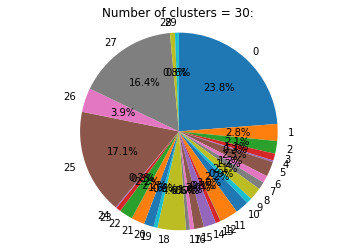

,Count (#),Percentage (%)
0,446,23.79
1,52,2.77
2,39,2.08
3,21,1.12
4,5,0.27
5,46,2.45
6,22,1.17
7,23,1.23
8,39,2.08
9,17,0.91


In [11]:
# show pie chart
df_clusters = pd.DataFrame(pd.Series(clusters).value_counts()).rename(
    columns = {0:'Count (#)'})
df_clusters = df_clusters.sort_index()
plt.title('Number of clusters = %d:' % k_pc)
plt.pie(df_clusters['Count (#)'], labels=df_clusters.index, autopct='%1.1f%%',
        startangle=90, counterclock=False)
plt.axis('equal')
plt.show()

# show frequency table
val_totcnt = sum(df_clusters['Count (#)'])
df_clusters['Percentage (%)'] = df_clusters['Count (#)'].apply(
    lambda x:round(x/val_totcnt*100, 2))
display(df_clusters)

## References
1) Stock market co-movement assessment using a three-phase clustering method: https://www.sciencedirect.com/science/article/abs/pii/S0957417413006404

2) Time series symbolic discretization with SAX: https://github.com/seninp/saxpy

3) kmodes: https://github.com/nicodv/kmodes